# Deep Learning

## Approximation of Growth Model

**Acknowledgement**: This notebook has been written by **[Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**.

Consider the canonical growth problem:

$\begin{align}
\quad & \max_{\{c_t\}_{t=0}^\infty } \sum \beta^t u(c_t)\\
\quad & \text{s.t.}\quad  k_{t+1} = f(k_t) + (1-\delta) k_t -c_t,\\
\quad & k_{t+1} \geq 0,\\
\quad & k_0 \quad \text{is given}.
\end{align}$

The Euler equation can be written as:

$\begin{align}
\quad & u'(c_t) = \beta u'(c_{t+1})\big[f'(k_{t+1})+(1-\delta)\big].
\end{align}$

To pin down the solution transversality condition is required:

$\begin{align}
\quad & \lim_{T\rightarrow \infty} u'(c_T)k_{T+1} = 0.
\end{align}$

The solution of this problem can be written as a **root** of the **functional operator**.

$\begin{align}
\quad & \beta u'\big(c(t+1)\big)\bigg[f'\big(k(t+1)\big)+(1-\delta)\bigg] - u'\big(c(t)\big) = 0, \\
\quad & f\big(k(t)\big) + (1-\delta) k(t) -c(t) - k(t+1)  = 0,\\
\quad & k(0)-k_0 = 0.
\end{align}$

This example assumes that
 1. $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, and $f(k) = k^\alpha$,

 2.  $\sigma = 1$, $\beta = 0.9$, $\alpha = \frac{1}{3}$.

### Load packages

Installation instructions for the [d2l package](https://www.d2l.ai/chapter_installation/index.html) and the [PyTorch package](https://pytorch.org/multipy/main/setup.html).

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsummary
from d2l import torch as d2l

### Define plotting setups 

In [2]:
fontsize= 14
ticksize = 14
figsize = (12, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

### Setting up the model's parameters

In [3]:
class Params(d2l.HyperParameters):
    def __init__(self,
                 alpha = 1.0/3.0,
                 beta = 0.9,
                 delta = 0.1,
                 k_0 = 1.0,
                ):
        self.save_hyperparameters()


### Define some useful functions:
$f(k)$: Production function

$f'(k)$: derivative of the production function

$SS$: Steady states of the capital and consumption

In [4]:
def f(k):
    alpha = Params().alpha
    return k**alpha

def f_prime(k):
    alpha = Params().alpha
    return  alpha*(k**(alpha -1))

def u_prime(c):
    out = c.pow(-1)
    return out

class SS: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        base = ((1.0/self.beta)-1.0+self.delta)/self.alpha
        exponent = 1.0/(self.alpha-1)
        self.k_ss = base**exponent
        self.c_ss = f(self.k_ss)-self.delta*self.k_ss

### Preparing the grid and the data loader (for stochastic gradient method)

In [5]:
class Grid_data(d2l.HyperParameters):
    def __init__(self,
                 max_T = 32,
                 batch_size = 8):
        self.save_hyperparameters()
        self.time_range = torch.arange(0.0, self.max_T , 1.0)
        self.grid = self.time_range.unsqueeze(dim = 1)

In [6]:
class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

In [7]:
train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )

### Defining the approximating function (neural networks):
Here the the approximation function (deep neural net) is $\hat{q}=[\hat{c},\hat{k}] : \mathbb{R} → \mathbb{R}^2$.


In [8]:
class NN(nn.Module, d2l.HyperParameters):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.save_hyperparameters()

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,2))
        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out

In [9]:
# Alternative Neural Network with ReLU activation functions
""" class NN(nn.Module, d2l.HyperParameters):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.save_hyperparameters()

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())

        module.append(nn.Linear(self.dim_hidden,2))
        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out """

' class NN(nn.Module, d2l.HyperParameters):\n    def __init__(self,\n                 dim_hidden = 128,\n                layers = 4,\n                hidden_bias = True):\n        super().__init__()\n        self.save_hyperparameters()\n\n        torch.manual_seed(123)\n        module = []\n        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))\n        module.append(nn.ReLU())\n\n        for i in range(self.layers-1):\n            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))\n            module.append(nn.ReLU())\n\n        module.append(nn.Linear(self.dim_hidden,2))\n        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0\n\n        self.q = nn.Sequential(*module)\n\n\n    def forward(self, x):\n        out = self.q(x) # first element is consumption, the second element is capital\n        return  out '

### Optimization (Learning) process

Auxiliary function that extracts the learning rate

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [11]:
class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

#### Initializing the neural net and defining the optimizer



In [12]:
q_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [13]:
print(q_hat)

NN(
  (q): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=2, bias=True)
    (9): Softplus(beta=1.0, threshold=20.0)
  )
)


In [14]:
# Torchsummary provides a more readable summary of the neural network
torchsummary.summary(q_hat, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
              Tanh-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              Tanh-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              Tanh-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              Tanh-8                  [-1, 128]               0
            Linear-9                    [-1, 2]             258
         Softplus-10                    [-1, 2]               0
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Tot

### Optimization of the network's weights

In [15]:
delta = Params().delta
beta = Params().beta
k_0 = Params().k_0

num_epochs = 1001

In [16]:
for epoch in range(num_epochs):
    for i, time in enumerate(train):
        time_zero = torch.zeros([1,1])
        time_next = time+1
        c_t = q_hat(time)[:,[0]]
        k_t = q_hat(time)[:,[1]]
        c_tp1 = q_hat(time_next)[:,[0]]
        k_tp1 = q_hat(time_next)[:,[1]]
        k_t0 = q_hat(time_zero)[0,1]

        res_1 = c_t-f(k_t)-(1-delta)*k_t + k_tp1 #Budget constraint
        res_2 = (u_prime(c_t)/u_prime(c_tp1)) - beta*(f_prime(k_tp1)+1-delta) #Euler
        res_3 = k_t0-k_0 #Initial Condition

        loss_1 = res_1.pow(2).mean()
        loss_2 = res_2.pow(2).mean()
        loss_3 = res_3.pow(2).mean()
        loss = 0.1*loss_1+0.8*loss_2+0.1*loss_3

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    scheduler.step()

    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',', 'loss_bc' , ',' , 'loss_euler' , ',' , 'loss_initial' ,
               ',', 'lr_rate')
    if epoch % 100 == 0:
          print(epoch,',',"{:.2e}".format(loss.detach().numpy()),',',
                "{:.2e}".format(loss_1.detach().numpy()) , ',' , "{:.2e}".format(loss_2.detach().numpy())
               , ',' , "{:.2e}".format(loss_3.detach().numpy()), ',', "{:.2e}".format(get_lr(optimizer)) )


epoch , loss , loss_bc , loss_euler , loss_initial , lr_rate
0 , 3.09e-03 , 1.26e-03 , 3.14e-03 , 4.55e-03 , 1.00e-03
100 , 1.02e-07 , 4.97e-07 , 6.55e-08 , 1.11e-09 , 8.00e-04
200 , 5.65e-08 , 5.74e-08 , 6.30e-08 , 3.58e-09 , 6.40e-04
300 , 1.86e-08 , 9.00e-08 , 1.20e-08 , 2.40e-12 , 5.12e-04
400 , 2.56e-08 , 1.65e-07 , 1.12e-08 , 2.83e-10 , 4.10e-04
500 , 1.68e-08 , 1.05e-07 , 7.78e-09 , 5.97e-10 , 3.28e-04
600 , 2.60e-08 , 2.32e-07 , 3.42e-09 , 3.82e-10 , 2.62e-04
700 , 9.06e-09 , 4.52e-08 , 5.63e-09 , 3.92e-10 , 2.10e-04
800 , 1.29e-08 , 1.08e-07 , 2.55e-09 , 3.11e-10 , 1.68e-04
900 , 6.66e-09 , 1.89e-08 , 5.94e-09 , 6.28e-11 , 1.34e-04
1000 , 7.68e-09 , 5.49e-08 , 2.72e-09 , 7.57e-11 , 1.07e-04


### Plotting the results


In [17]:
time_test = Grid_data().grid
c_hat_path = q_hat(time_test)[:,[0]].detach()
k_hat_path = q_hat(time_test)[:,[1]].detach()

/var/folders/d8/rg4nc_vs73l0c196ylpc1cyh0000gn/T/ipykernel_19759/1952787435.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


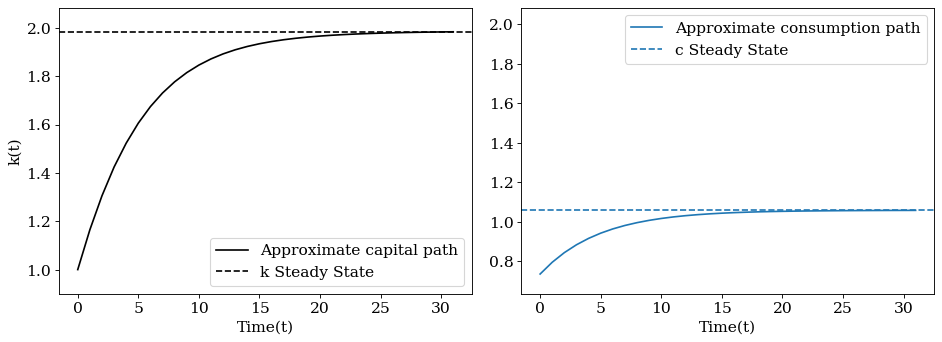

In [18]:
plt.subplot(1, 2, 1)


plt.plot(time_test,k_hat_path, color='k',  label = r"Approximate capital path")
plt.axhline(y=SS().k_ss, linestyle='--',color='k', label="k Steady State")
plt.ylabel(r"k(t)")
plt.xlabel(r"Time(t)")
plt.ylim([Params().k_0-0.1,SS().k_ss+0.1 ])
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(time_test,c_hat_path,label= r"Approximate consumption path")
plt.axhline(y=SS().c_ss, linestyle='--',label="c Steady State")
plt.xlabel(r"Time(t)")
plt.ylim([c_hat_path[0]-0.1,SS().k_ss+0.1 ])
plt.tight_layout()
plt.legend(loc='best')
plt.tight_layout()
plt.show()
